In [45]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [46]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [168]:
columns = ['PERMIT_ID', 'UNITS', 'NET_UNITS', 'BESTSTAT', 'BESTDATE', 'YEAR', 'QUARTER']
# AFF_UNITS, NET_AFF_UNITS, NAMEADDR, APN
distinct_columns = ['PERMIT_ID']

def loadData():
    file_name = "data_complete/PipelineCleaned_"
    data = []
    for year in range(2014, 2018):
        for q in range(1, 5):
            if year == 2017 and q == 2:
                break
            X = pd.read_csv(file_name + str(year) + "_Q" + str(q) + ".csv", sep=',', infer_datetime_format=True)
            X["YEAR"] = year
            X["QUARTER"] = q
            data.append(X)
    df = pd.concat(data)
    return df
df = loadData()
#print(df.head())
df = df[columns]
df["BESTSTAT"] = df["BESTSTAT"].str.upper()
df["BESTSTAT"][(df["BESTSTAT"] == "BP APPROVED") | (df["BESTSTAT"] == "PL APPROVED")] = "APPROVED"
df["BESTSTAT"][(df["BESTSTAT"] == "BP FILED") | (df["BESTSTAT"] == "PL FILED")] = "FILED"
df = df[df["BESTSTAT"] == "CONSTRUCTION"]
df.drop(["BESTSTAT"], inplace=True, axis=1)
df['BESTDATE'] = pd.to_datetime(df['BESTDATE'], errors='coerce') # format='%m/%d/%Y', 
df.head()
#df.groupby("BESTSTAT").count()

/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,PERMIT_ID,UNITS,NET_UNITS,BESTDATE,YEAR,QUARTER
1,N200505273609,1,1,2014-01-24,2014,1
4,N200608179803,2,1,2014-02-04,2014,1
7,N200605111391,2,2,2014-03-18,2014,1
11,N200904065665,6,6,2013-01-08,2014,1
18,N201205180774,37,37,2014-01-08,2014,1


In [179]:
#df[(df["BESTSTAT"] == "CONSTRUCTION") & (df["YEAR"] == 2014)].sort_values(by=['NET_UNITS'], ascending=False)
#construction_start = df.sort(['BESTDATE', 'YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
construction_start = df.sort(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="first")
#construction_start.rename(columns = {'BESTDATE':'STARTDATE'}, inplace = True)

construction_end = df.sort(['YEAR', 'QUARTER']).drop_duplicates(subset=distinct_columns, keep="last")
#construction_end.rename(columns = {'BESTDATE':'ENDDATE'}, inplace = True)


data = pd.merge(construction_start[['PERMIT_ID', 'YEAR', 'QUARTER']], construction_end, 
                how='inner', on=['PERMIT_ID'], left_on=None, right_on=None, suffixes=('_START', '_END'))
# not applicable as BESTDATE seems not to be updated 
#data['DURATION'] = (data['ENDDATE'] - data['STARTDATE']) / np.timedelta64(1, 'D')

data['DURATION'] = (data['YEAR_END'] - data['YEAR_START']) * 4 + data['QUARTER_END'] - data['QUARTER_START'] + 1
data = data[['PERMIT_ID', 'UNITS', 'NET_UNITS', 'YEAR_START', 'QUARTER_START', 'YEAR_END', 'QUARTER_END', 'DURATION']]
data.head()

/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()
/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,PERMIT_ID,UNITS,NET_UNITS,YEAR_START,QUARTER_START,YEAR_END,QUARTER_END,DURATION
0,N200505273609,1,1,2014,1,2015,1,5
1,N200608179803,2,1,2014,1,2017,1,13
2,N200605111391,2,2,2014,1,2017,1,13
3,N200904065665,6,6,2014,1,2016,1,9
4,N201205180774,37,37,2014,1,2014,4,4


In [180]:
print(data.count())
print(data[data['DURATION'] > 1].count())
#data = data[data['DURATION'] > 0]
#g = data.groupby(['PERMIT_ID'])
#data = g.filter(lambda x: len(x) == 2)

PERMIT_ID        565
UNITS            565
NET_UNITS        565
YEAR_START       565
QUARTER_START    565
YEAR_END         565
QUARTER_END      565
DURATION         565
dtype: int64
PERMIT_ID        478
UNITS            478
NET_UNITS        478
YEAR_START       478
QUARTER_START    478
YEAR_END         478
QUARTER_END      478
DURATION         478
dtype: int64


In [181]:
not_completed_ids = data[(data['YEAR_END'] == 2017)]['PERMIT_ID']
complete = data[~data['PERMIT_ID'].isin(not_completed_ids)]
incomplete = data[data['PERMIT_ID'].isin(not_completed_ids)]
print(complete.count())
print(incomplete.count())

PERMIT_ID        382
UNITS            382
NET_UNITS        382
YEAR_START       382
QUARTER_START    382
YEAR_END         382
QUARTER_END      382
DURATION         382
dtype: int64
PERMIT_ID        183
UNITS            183
NET_UNITS        183
YEAR_START       183
QUARTER_START    183
YEAR_END         183
QUARTER_END      183
DURATION         183
dtype: int64


In [185]:
complete.sort(['NET_UNITS'], ascending=False)

/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,PERMIT_ID,UNITS,NET_UNITS,YEAR_START,QUARTER_START,YEAR_END,QUARTER_END,DURATION
172,N201207124717,656,656,2014,2,2016,1,8
233,N201306250394,560,560,2014,4,2016,3,8
234,N201112070227,470,470,2014,4,2016,3,8
209,N200605161774,452,452,2014,3,2015,4,6
138,N201209059006,450,450,2014,1,2016,2,10
235,N201307303137,416,416,2014,4,2016,4,9
192,N201304023626,409,409,2014,2,2015,3,6
125,N201208026344,399,399,2014,1,2014,4,4
212,N201112070234,393,393,2014,3,2016,1,7
19,N201009140800,320,320,2014,1,2015,2,6


In [200]:
print("Median ", complete['DURATION'].median())
print("Mean ", str(complete['DURATION'].mean()))

print("Median net units", complete['NET_UNITS'].median()) # few big buildings
#print("Long in costruction, net units: ", complete[complete['DURATION'] > 4]['NET_UNITS'].mean())
#print("Not long in costruction, net units: ", complete[complete['DURATION'] <= 4]['NET_UNITS'].mean())

# not much difference
print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].mean())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].mean())

print("Bigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].median())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].median())

Median  4.0
Mean  4.570680628272251
Median net units 1.0

Bigger buildings:  5.162162162162162
Smaller buildings:  4.428571428571429
Bigger buildings:  5.0
Smaller buildings:  4.0


In [201]:
complete = complete[complete['DURATION'] > 1] # remove 1-quarter buildings

In [214]:
print("Median ", complete['DURATION'].median())
print("Mean ", str(complete['DURATION'].mean()))

print("\nBigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].mean())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].mean())

print("Bigger buildings: ", complete[complete['NET_UNITS'] > 20]['DURATION'].median())
print("Smaller buildings: ", complete[complete['NET_UNITS'] <= 20]['DURATION'].median())

Median  5.0
Mean  5.17125382262997

Bigger buildings:  5.666666666666667
Smaller buildings:  5.045977011494253
Bigger buildings:  6.0
Smaller buildings:  4.0


/Users/anastasia/Development/TOOLS/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


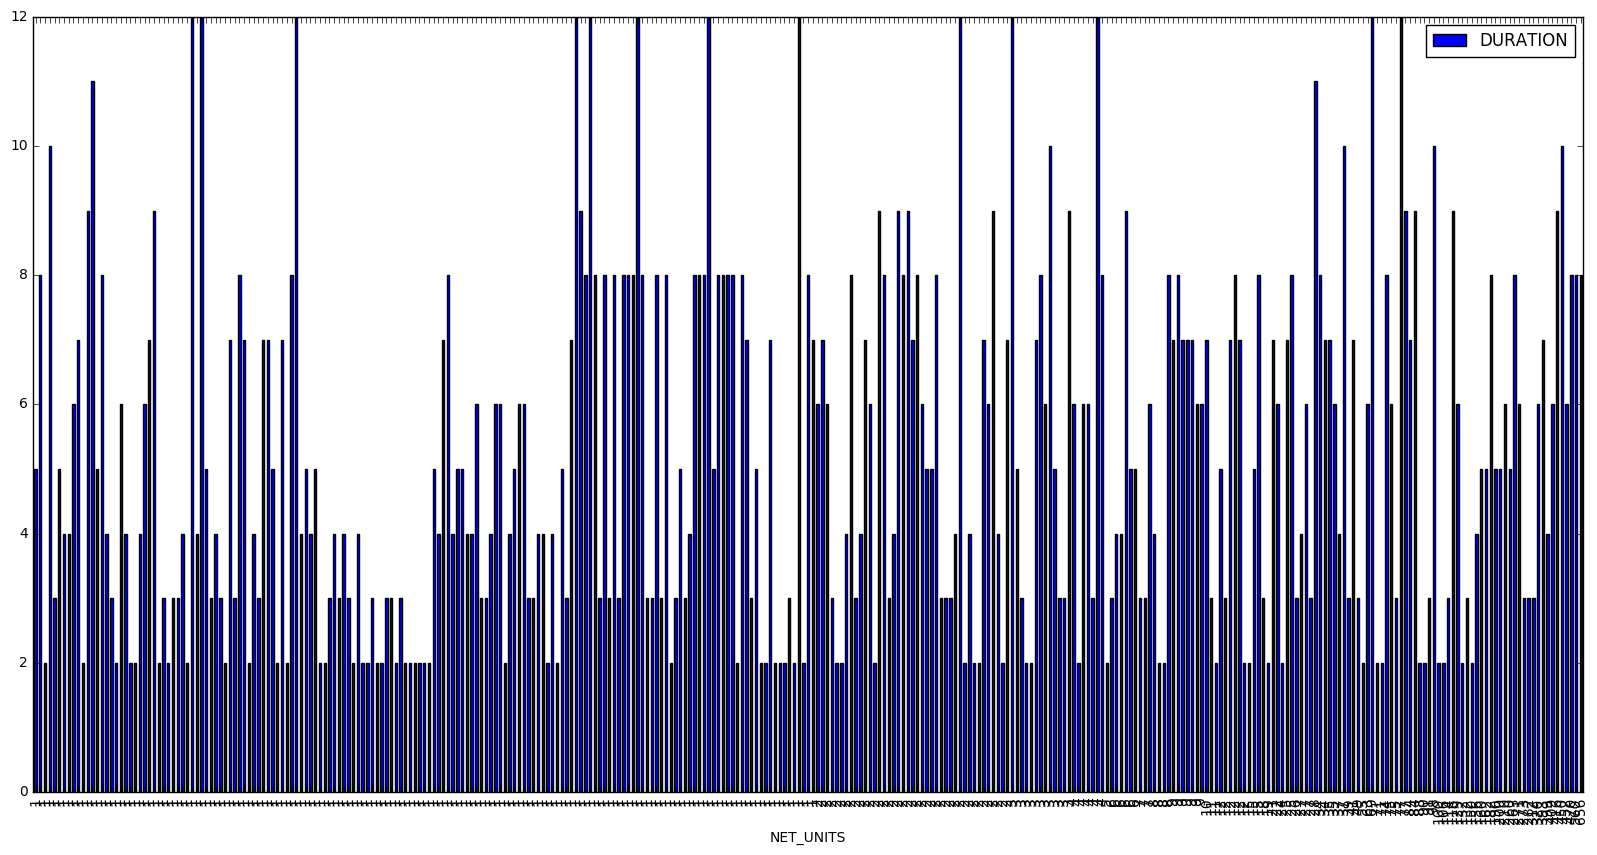

In [213]:
# net units to duration
complete.sort(['NET_UNITS']).plot(x = 'NET_UNITS', y = 'DURATION', kind = "bar", figsize=(20,10))

In [96]:
data[data["PERMIT_ID"] == "N200903134091"]

,PERMIT_ID,UNITS,NET_UNITS,AFF_UNITS,NET_AFF_UNITS,NAMEADDR,APN,BESTSTAT,BESTDATE,YEAR,QUARTER
35,N200903134091,113,113,0,0,429 BEALE ST,3767305,APPROVED,2009-05-14,2015,3


Approved permits in the last quarter with construction not started